# Overview

## Aim
To interpret the simulation results, it is essential to compare the direction of the perturbation effect with the developmental flow of the trajectory. This comparison will allow us to assess the perturbation’s overall effect (i.e. block or promote differentiation), and  intuitively understand how TF is involved in cell fate determination during development.


## Method summary
For that purpose, we will introduce how to calculate the direction of differentiation using "pseudotime estimation" and "gradient calculation". Here's an overview of how to do this:

1. Calculate the pseudotime using the diffusion pseudotime method (dpt).
2. Transfer pseudotime data to grid points
3. Calculate the 2D gradient vector field using the pseudotime on the grid points
4. Compare the perturbation and pseudotime vector fields by computing their inner product values.


**In this notebook, we will do step1: pseudotime calculation.**
This step is divided into the following parts: 

1. Set the lineage information and split the cells into several lineage brahches.
2. Set root cells for each lineage.
3. Calculate pseudotime with DPT algorithm.
4. Re-aggregate scRNA-seq data into one data

## Custom class / object

`Pseudotime_calculator`: This is a class for the pseudotime calculation. This class help us calculate pseudotime from scRNA-seq data. We need to specify a root cell. Also, scRNA-seq need to have a diffusion map.
>Under the hood, the `Pseudotime_calculator` uses "dpt" algorithm.
For more information of dpt algorithm and root cell, please look at the scanpy web documentation.
https://scanpy.readthedocs.io/en/stable/api/scanpy.tl.dpt.html#scanpy.tl.dpt

## Data

Pseudo-time calculation requires preprocessed scRNA-seq data in anndata format.
You need to do neighbor calculation and diffusion map calculation in advance. If you have processed the scRNA-seq data according to our tutorial, these calculations have already been performed.
- Neighbor calculation: https://scanpy.readthedocs.io/en/stable/generated/scanpy.pp.neighbors.html#scanpy.pp.neighbors
- Diffusion map calculation: https://scanpy.readthedocs.io/en/stable/generated/scanpy.tl.diffmap.html#scanpy.tl.diffmap


## Install additional python package (This is an optional step.)

This notebook we recommend using another python package, `plotly`. 

Please install `plotly` in advance. 

`pip install plotly`

> Plotly is a toolkit for interactive visualization.
We recommend using plotly to pick up root cells in this notebook.
For more information, please look at plotly web site. https://plotly.com



## Caution
Here, we will introduce an example of a pseudotime calculation using the diffusion pseudotime method. This is NOT CellOracle analysis itself, but just a data preparation step.
In addition to the dpt method introduced here, CellOracle also accepts output from any pseudotime method.


# 0. Import libraries
## 0.1. Import public libraries

In [1]:
import copy
import glob
import time
import os
import shutil
import sys

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scanpy as sc
import seaborn as sns
from tqdm.notebook import tqdm

#import time

## 0.2. Import our library

In [2]:
import celloracle as co
from celloracle.applications import Pseudotime_calculator
co.__version__

'0.10.1'

## 0.3. Plotting parameter setting

In [3]:
#plt.rcParams["font.family"] = "arial"
plt.rcParams["figure.figsize"] = [5,5]
%config InlineBackend.figure_format = 'retina'
plt.rcParams["savefig.dpi"] = 300

%matplotlib inline

# 1. Load data

- If you have `Oracle` object, please run **1.1.[Option1] Load oracle data.**

- If you have not made an `Oracle` object yet and want to calculate pseudotime using `Anndata` object, please run **1.2.[Option2] Load anndata.** 

In this notebook, we will load demo `Oracle` object and add pseudotime information to it.

## 1.1. [Option1] Load oracle data

In [4]:
# Load demo scRNA-seq data.
oracle = co.data.load_tutorial_oracle_object()

# Instantiate pseudotime object using oracle object.
pt = Pseudotime_calculator(oracle_object=oracle)

## 1.2. [Option2] Load anndata

In [5]:
# Load demo scRNA-seq data.
adata = co.data.load_Paul2015_data()

# Instantiate pseudotime object using anndata object.
pt = Pseudotime_calculator(adata=adata,
                           obsm_key="X_draw_graph_fa", # Dimensional reduction data name
                           cluster_column_name="louvain_annot" # Clustering data name
                           )


# 2. Pseudotime calculation

## 2.1. Add lineage information

Pseudotime calculation can be done for each lineage. We can define these lineages below.

### 2.1.1 Check clustering unit

In [6]:
print("Clustering name: ", pt.cluster_column_name)
print("Cluster list", pt.cluster_list)

Clustering name:  louvain_annot
Cluster list ['Ery_0', 'Ery_1', 'Ery_2', 'Ery_3', 'Ery_4', 'Ery_5', 'Ery_6', 'Ery_7', 'Ery_8', 'Ery_9', 'GMP_0', 'GMP_1', 'GMP_2', 'GMPl_0', 'GMPl_1', 'Gran_0', 'Gran_1', 'Gran_2', 'Gran_3', 'MEP_0', 'Mk_0', 'Mo_0', 'Mo_1', 'Mo_2']


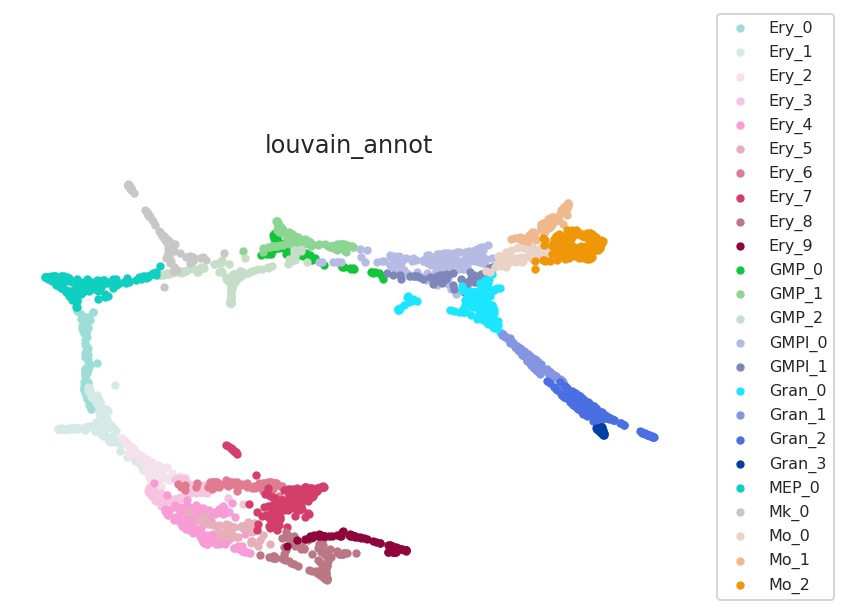

In [7]:
# Check data
pt.plot_cluster(fontsize=8)

### 2.1.2. Define llineage

We will make lineage annotation on the scRNA-seq data.
For example, the demo scRNA-seq data include roughly two lineages: megakaryocytes-erythroid (ME) lineage and granulocytes-monocyte (GM) lineage.

To get better pseudotime information, calculate the pseudotime for each cell lineage individually.
Then, all pseudotime information of each lineage are merged into one.

Lineages can be specified using lists.  The lineage structure and number of branches will vary depending on the dataset. Please adjust the code as necessary to match your data. 

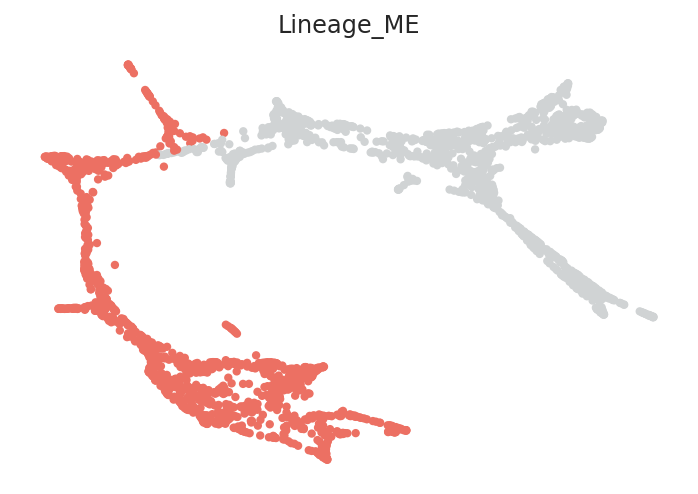

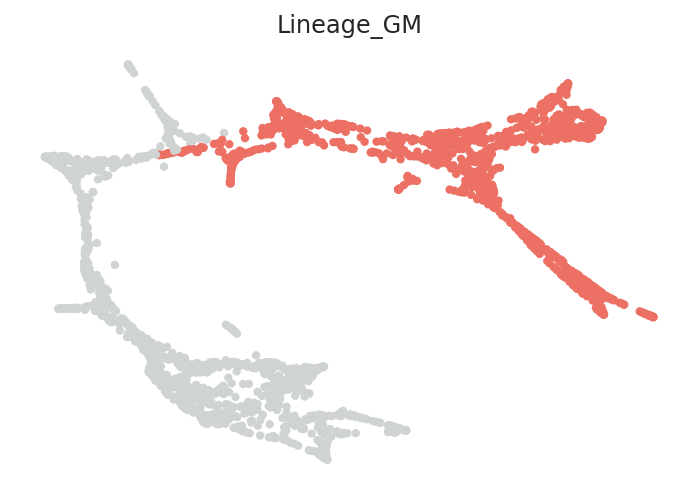

In [8]:
# Here, clusters can be classified into either MEP lineage or GMP lineage

clusters_in_ME_lineage = ['Ery_0', 'Ery_1', 'Ery_2', 'Ery_3', 'Ery_4', 'Ery_5', 
                          'Ery_6', 'Ery_7', 'Ery_8', 'Ery_9', 'MEP_0', 'Mk_0']
clusters_in_GM_lineage = ['GMP_0', 'GMP_1', 'GMP_2', 'GMPl_0', 'GMPl_1', 'Gran_0', 
                          'Gran_1', 'Gran_2', 'Gran_3', 'Mo_0', 'Mo_1', 'Mo_2']

# Make a dictionary
lineage_dictionary = {"Lineage_ME": clusters_in_ME_lineage,
           "Lineage_GM": clusters_in_GM_lineage}

# Input lineage information into pseudotime object
pt.set_lineage(lineage_dictionary=lineage_dictionary)

# Visualize lineage information
pt.plot_lineages()

## 2.2. Add root cell information

The DPT pseudotime calculation requires the user to specify a root cell.
We will manually estimate the root cell for each lineage.

Please read documentation (https://scanpy.readthedocs.io/en/stable/api/scanpy.tl.dpt.html#scanpy.tl.dpt) to find detailed information about the DPT algorithm and root cells

### 2.2.1. (Optional step) Interactive visualization of cell name 

We recommend using another python package, `plotly` to find the cell id for root cell. 

Please install `plotly` in advance. 

`pip install plotly`

> Plotly is a toolkit for interactive visualization.
We recommend using plotly to pick up root cells in this notebook.
For more information, please look at plotly web site. https://plotly.com




**Using plotly, we can visualize cell IDs interactively. It helps us pick up a root cell.**
This is an example image.
<img src="
https://raw.githubusercontent.com/morris-lab/CellOracle/master/docs/demo_data/screenshot_01.png">



In [ ]:
# Show interactive plot using plotly. Please make sure that plotly is installed. 

try:
    import plotly.express as px
    def plot(adata, embedding_key, cluster_column_name):
        embedding = adata.obsm[embedding_key]
        df = pd.DataFrame(embedding, columns=["x", "y"])
        df["cluster"] = adata.obs[cluster_column_name].values
        df["label"] = adata.obs.index.values
        fig = px.scatter(df, x="x", y="y", hover_name=df["label"], color="cluster")
        fig.show()
        
    plot(adata=pt.adata,
         embedding_key=pt.obsm_key,
         cluster_column_name=pt.cluster_column_name)
except:
    print("Plotly not found in your environment. Did you install plotly? Please read the instruction above.")


### 2.2.2. Select root cell for each lineage

In [9]:
# Estimated root cell name for each lineage
root_cells = {"Lineage_MEP": "1539", "Lineage_GMP": "2244"}
pt.set_root_cells(root_cells=root_cells)

NameError: name 'lineaeg' is not defined

### 2.2.3. Visualize root cells 

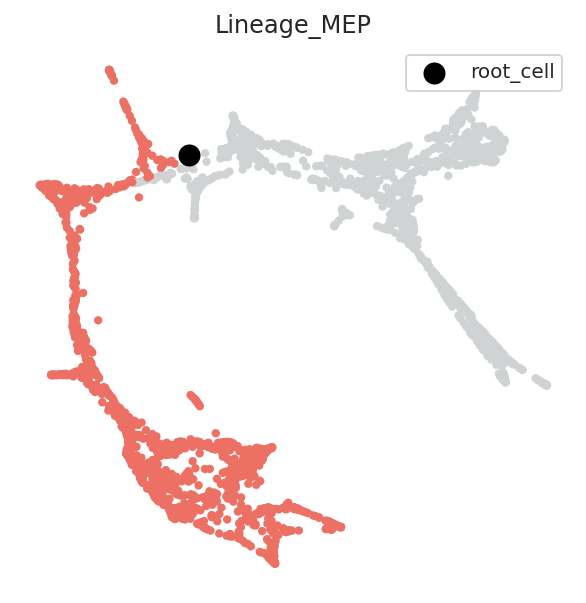

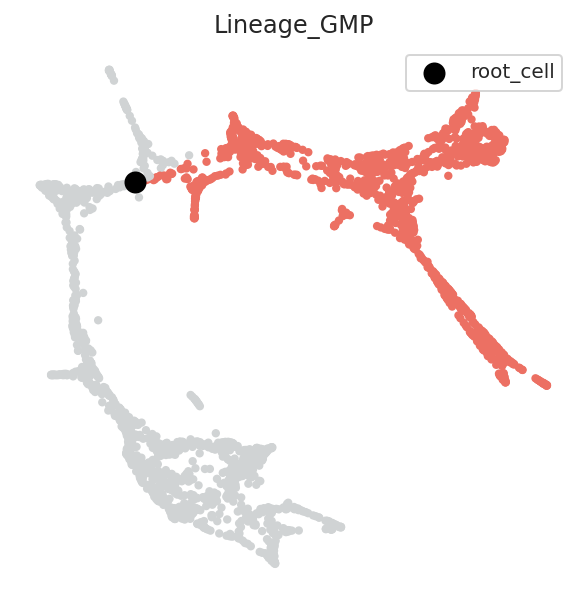

In [11]:
# Check root cell and lineage
pt.plot_root_cells()

## 2.3. Pseudotime calculation

You need to calculate neighbors and the diffusion map before funning DPT. If you have processed the scRNA-seq data according to our tutorial, these calculations have already been performed.
- Neighbor calculation: https://scanpy.readthedocs.io/en/stable/generated/scanpy.pp.neighbors.html#scanpy.pp.neighbors
- Diffusion map calculation: https://scanpy.readthedocs.io/en/stable/generated/scanpy.tl.diffmap.html#scanpy.tl.diffmap


### 2.3.1. Check diffusion map 

In [36]:
# Check diffusion map data.
"X_diffmap" in pt.adata.obsm

True

Calculate diffusion map if your anndata object does not have diffusion map data.

In [13]:
# sc.pp.neighbors(pt.adata, n_neighbors=30)
# sc.tl.diffmap(pt.adata)

Diffusion maps can be calculated using another dimensionality reduction space. Please adjust the “use_rep” parameter to specify alternate embeddings. 

In [14]:
# sc.pp.neighbors(pt.adata, n_neighbors=30, use_rep=)
# sc.tl.diffmap(pt.adata)

### 2.3.2. Calculate pseudotime

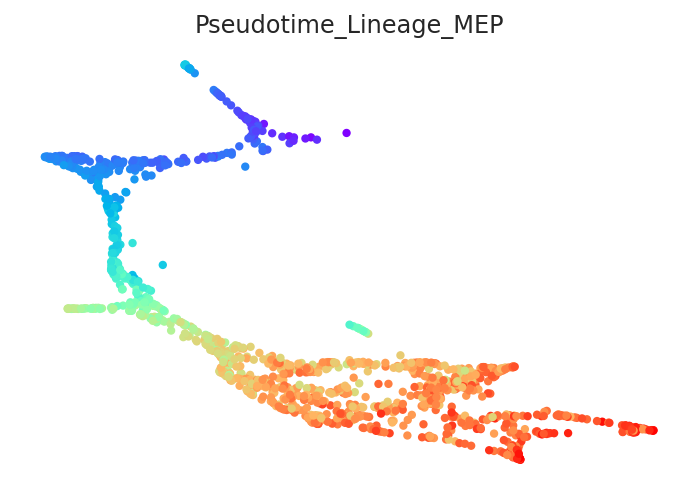

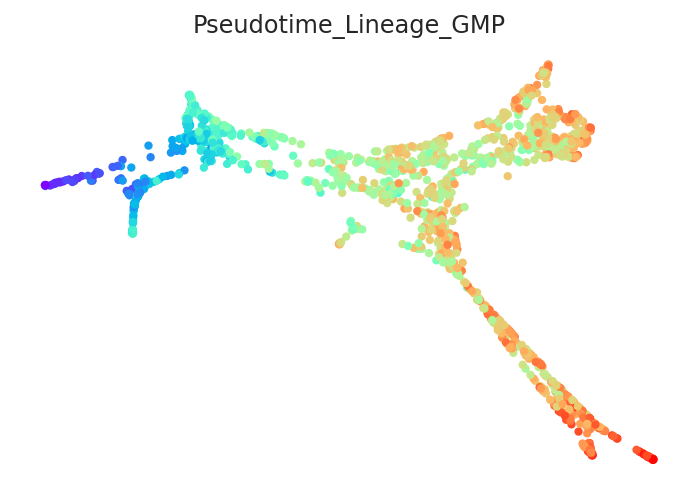

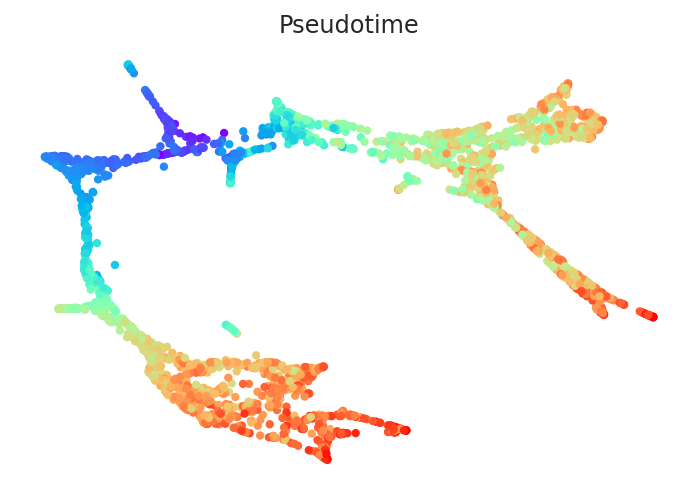

In [39]:
# Calculate pseudotime
pt.get_pseudotime_per_each_lineage()

# Check results
pt.plot_pseudotime(cmap="rainbow")

Pseudotime data is stored in the `pt.adata.obs.Pseudotime`

In [41]:
# Check result 
pt.adata.obs[["Pseudotime"]].head()

,Pseudotime
index,
0,0.175565
1,0.712654
2,0.953920
3,0.642302
4,0.951093


# 3. Save data

## 3.1. If you started calculation with an oracle object

In [17]:
# Add calculated pseudotime data to the oracle object
oracle.adata.obs = pt.adata.obs

# Save updated oracle object
oracle.to_hdf5(FILE_PATH)

## 3.2. If you started calculation with anndata 

In [ ]:
# Add calculated pseudotime data to the oracle object
#adata.obs = pt.adata.obs

# Save updated anndata object
#adata.write_h5ad(FILE_PATH)